# Deep CTR (Attention and Self-attention)

In [1]:
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from deepctr_torch.models import DeepFM
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
)


In [2]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'imdb_url']
movies = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
                                                  'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                                                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                     dtype={'release_date': "S100", 'imdb_url': "S200"},encoding='ansi')

# create one merged DataFrame
movie_ratings = pd.merge(movies[['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']], ratings)
data = pd.merge(movie_ratings, users)
data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [3]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

#if __name__ == "__main__":

#data = pd.read_csv('C:\\Users\\Lina\\DeepCTR-Torch\\examples\\movielens_sample.txt', sep=',')
sparse_features = ["movie_id", "user_id",
                       "sex", "age", "occupation", "zip_code"]
target = ['rating']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    # 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model
train, test = train_test_split(data, test_size=0.15)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}
    # 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=50, verbose=2, validation_split=0.2)

pred_ans = model.predict(test_model_input, batch_size=256)
rmse=math.sqrt(round(mean_squared_error(test[target].values, pred_ans), 4))
print("test RMSE",rmse )



cpu
Train on 68000 samples, validate on 17000 samples, 266 steps per epoch
Epoch 1/50
10s - loss:  2.0533 - mse:  2.0515 - val_mse:  0.8936
Epoch 2/50
12s - loss:  0.8866 - mse:  0.8866 - val_mse:  0.8741
Epoch 3/50
11s - loss:  0.8700 - mse:  0.8698 - val_mse:  0.8830
Epoch 4/50
11s - loss:  0.8642 - mse:  0.8643 - val_mse:  0.8736
Epoch 5/50
10s - loss:  0.8612 - mse:  0.8608 - val_mse:  0.8736
Epoch 6/50
10s - loss:  0.8589 - mse:  0.8591 - val_mse:  0.8787
Epoch 7/50
10s - loss:  0.8590 - mse:  0.8587 - val_mse:  0.8832
Epoch 8/50
10s - loss:  0.8573 - mse:  0.8576 - val_mse:  0.8741
Epoch 9/50
9s - loss:  0.8564 - mse:  0.8563 - val_mse:  0.8747
Epoch 10/50
10s - loss:  0.8547 - mse:  0.8549 - val_mse:  0.8755
Epoch 11/50
10s - loss:  0.8534 - mse:  0.8533 - val_mse:  0.8733
Epoch 12/50
10s - loss:  0.8531 - mse:  0.8531 - val_mse:  0.8732
Epoch 13/50
10s - loss:  0.8522 - mse:  0.8524 - val_mse:  0.8727
Epoch 14/50
10s - loss:  0.8518 - mse:  0.8518 - val_mse:  0.8725
Epoch 15/50

In [5]:
test_model_input

{'movie_id': 89860     729
 84449      39
 66849     508
 92608    1062
 6331      939
 13592    1486
 24498     712
 49661     561
 15013     241
 58334    1000
 45122      81
 21424     142
 57113    1148
 7028      356
 50143     661
 51295    1131
 86622     603
 19662     525
 72459     187
 66713      13
 36573     650
 89877    1192
 29167     229
 23097     175
 7457      201
 65365     365
 36657     155
 8721      186
 98445     747
 50         87
          ... 
 75962     338
 4547      476
 47535     384
 42694     988
 61438    1189
 33169      21
 53614     614
 17687     149
 64681       6
 89643     477
 35657     958
 31485     865
 8341       47
 27979     136
 29533     495
 47794     127
 95247    1663
 41028     133
 82272     632
 72424      75
 65517     941
 85421     214
 39060     483
 39485    1229
 83273     242
 92182     153
 49690      69
 58898     392
 85985     178
 53298       8
 Name: movie_id, Length: 15000, dtype: int64, 'user_id': 89860    584
 84

In [6]:
mean_squared_error(test[target].values, pred_ans)

0.887647773267942

In [7]:
mean_absolute_error(test[target].values, pred_ans)

0.7409612095624208

In [8]:
r2_score(test[target].values, pred_ans)

0.3130412078786814

In [9]:
explained_variance_score(test[target].values, pred_ans)

0.31476160508631856

___________________________________________________________________________

# Autoencoders

In [25]:
## -*- coding: utf-8 -*-

#ratings-u.data df
#movies-u.item movie_df

In [10]:
data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,0,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,307,4,887736532,50,1,15,716
1,3,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,307,5,887737890,50,1,15,716
2,4,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),307,4,887739608,50,1,15,716
3,6,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,307,4,887738847,50,1,15,716
4,7,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),307,5,887736696,50,1,15,716


In [11]:
# capture all genre columns, get them to one column, remove them after it is done
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies['genre'] = movies[genres].idxmax(1)
movies = movies.drop(genres, axis=1)
movies.head(5)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [12]:
movies = movies[['movie_id', 'movie_title', 'release_date', 'IMDb_URL', 'genre']]

In [13]:
movies.head(5)

,movie_id,movie_title,release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [14]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = data.pivot(index   = 'user_id', 
                                 columns = 'movie_id', 
                                 values  = 'rating').fillna(0)
users_items_matrix_df.head(10)

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
users_items_matrix_df.shape

(943, 1682)

In [16]:
users_items_matrix_df.values.mean()*100

22.254600202001605

In [17]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [18]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [19]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 1682)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               861696    
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
____________________________________________________________

In [20]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.15)


Train on 801 samples, validate on 142 samples
Epoch 1/50
801/801 [==============================] - ETA: 29s - loss: 2.61 - ETA: 14s - loss: 2.46 - ETA: 8s - loss: 2.3288 - ETA: 6s - loss: 2.338 - ETA: 4s - loss: 2.309 - ETA: 3s - loss: 2.284 - ETA: 2s - loss: 2.233 - ETA: 1s - loss: 2.207 - ETA: 1s - loss: 2.162 - ETA: 0s - loss: 2.170 - ETA: 0s - loss: 2.172 - ETA: 0s - loss: 2.164 - 4s 5ms/step - loss: 2.1493 - val_loss: 1.1371
Epoch 2/50
801/801 [==============================] - ETA: 0s - loss: 1.900 - ETA: 0s - loss: 1.936 - ETA: 0s - loss: 1.906 - ETA: 0s - loss: 1.868 - ETA: 0s - loss: 1.875 - ETA: 0s - loss: 1.869 - ETA: 0s - loss: 1.875 - ETA: 0s - loss: 1.866 - ETA: 0s - loss: 1.850 - ETA: 0s - loss: 1.868 - ETA: 0s - loss: 1.874 - ETA: 0s - loss: 1.872 - 1s 1ms/step - loss: 1.8700 - val_loss: 1.0835
Epoch 3/50
801/801 [==============================] - ETA: 0s - loss: 1.915 - ETA: 0s - loss: 1.853 - ETA: 0s - loss: 1.820 - ETA: 0s - loss: 1.785 - ETA: 0s - loss: 1.743 - ET

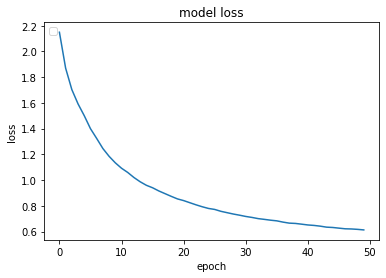

In [21]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [22]:
# Predict new Matrix Interactions, set score zero on visualized movies
new_matrix = model.predict(X) * (X == 0)

In [23]:
new_matrix

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.8658434e-02,  8.7607726e-03,  1.8559335e-01],
       [ 0.0000000e+00, -3.9456218e-01,  1.0221298e-01, ...,
        -1.0183171e-01,  2.0287983e-02, -9.5253281e-02],
       [ 3.2132411e-01,  8.0998279e-02, -1.1220820e-01, ...,
        -1.8878640e-03, -1.1763811e-02,  7.9218768e-02],
       ...,
       [ 0.0000000e+00, -1.2130818e-01,  4.2970511e-01, ...,
        -1.4438718e-02, -1.3333458e-02, -1.7097841e-01],
       [ 1.7578622e+00,  4.9307304e-03,  3.2896397e-01, ...,
         7.0354931e-02,  6.0918927e-02, -3.7910514e-02],
       [ 2.4745688e+00,  0.0000000e+00,  9.5556837e-01, ...,
         1.8646489e-01,  3.2458492e-02,  6.7016277e-03]], dtype=float32)

In [24]:
mean_absolute_error(X, new_matrix)

0.4207903381452538

In [25]:
r2_score(X, new_matrix)

-0.7473602626796056

In [26]:
explained_variance_score(X, new_matrix)

-0.678669231417907

In [27]:
mean_squared_error(X, new_matrix)

0.9985592337376044

In [28]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.085476,-0.012067,0.214147,0.013245,0.044376,-0.032004,-0.009638,-0.068658,0.008761,0.185593
1,0.000000,-0.394562,0.102213,0.108073,-0.034251,0.043640,1.834491,0.196527,1.679227,0.000000,...,0.016850,-0.223503,-0.082899,-0.109200,0.017823,-0.134544,0.015594,-0.101832,0.020288,-0.095253
2,0.321324,0.080998,-0.112208,0.206763,-0.046893,-0.007382,0.479661,-0.056783,0.087713,-0.320921,...,0.000913,-0.049951,0.061676,0.031488,-0.167946,0.048429,0.124079,-0.001888,-0.011764,0.079219
3,1.165467,-0.015941,0.073220,-0.115586,0.229209,-0.093964,0.233713,-0.164050,-0.130987,-0.413889,...,-0.031385,0.055602,-0.053981,0.052083,-0.176241,-0.006529,0.049922,-0.164043,-0.156500,0.131353
4,0.000000,0.000000,0.426959,1.183659,0.531341,-0.043707,1.801399,1.194629,0.304314,-0.097920,...,-0.273082,0.016915,-0.098091,0.055354,0.048140,-0.140241,0.040908,-0.160742,-0.019360,-0.008112


In [29]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-1.3996098 4.696064


In [30]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'movie_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('movie_id')\
                    .join(df_content.set_index('movie_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'movie_title']]
    
    return df_rec[df_rec.score > 0]

In [31]:
recommender_for_user(
    user_id         = 5, 
    interact_matrix = users_items_matrix_df, 
    df_content      = movies)

,score,movie_title
movie_id,,
473,5.0,James and the Giant Peach (1996)
492,5.0,East of Eden (1955)
489,5.0,Notorious (1946)
488,5.0,Sunset Blvd. (1950)
487,5.0,Roman Holiday (1953)
486,5.0,Sabrina (1954)
484,5.0,"Maltese Falcon, The (1941)"
483,5.0,Casablanca (1942)
482,5.0,Some Like It Hot (1959)


In [32]:
recommender_for_user(
    user_id         = 5, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = movies)

,score,movie_title
movie_id,,
602,3.565884,"American in Paris, An (1951)"
180,3.168217,Apocalypse Now (1979)
171,3.131686,Delicatessen (1991)
653,2.834927,Touch of Evil (1958)
178,2.697245,12 Angry Men (1957)
209,2.601289,This Is Spinal Tap (1984)
581,2.491418,Kalifornia (1993)
704,2.464216,"House of the Spirits, The (1993)"
656,2.429317,M (1931)


In [33]:
movies[movies.movie_id==142]

,movie_id,movie_title,release_date,IMDb_URL,genre
141,142,Bedknobs and Broomsticks (1971),b'01-Jan-1971',http://us.imdb.com/M/title-exact?Bedknobs%20an...,Adventure


In [34]:
movies[movies.movie_id==37]

,movie_id,movie_title,release_date,IMDb_URL,genre
36,37,Nadja (1994),b'01-Jan-1994',http://us.imdb.com/M/title-exact?Nadja%20(1994),Drama


In [35]:
movies[movies.movie_id==68]

,movie_id,movie_title,release_date,IMDb_URL,genre
67,68,"Crow, The (1994)",b'01-Jan-1994',"http://us.imdb.com/M/title-exact?Crow,%20The%2...",Action


In [36]:
movies[movies.movie_id==74]

,movie_id,movie_title,release_date,IMDb_URL,genre
73,74,Faster Pussycat! Kill! Kill! (1965),b'01-Jan-1965',http://us.imdb.com/M/title-exact?Faster%20Puss...,Action
